# Imports

In [37]:
import numpy as np
from typing import Callable
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define classes and distances

In [38]:
class MaxNet:
    def __init__(self,
                 input_num: int,
                 epsilon: float = 1e-2,
                 max_iteration: int = 100000) -> None:
        """maxnet layer

        Args:
            input_num (int): number of inputs
            epsilon (float, optional): minimal delta. Defaults to 1e-2.
            max_iteration (int, optional): max iteration. Defaults to 100000.
        """
        self._weights = np.eye(input_num) * (1 + epsilon) - np.ones(
            (input_num, input_num)) * epsilon
        self._max_iteration = max_iteration
        self.epsilon = epsilon

    def predict(self, x_vector: np.ndarray) -> np.ndarray:
        """Calculate maximum of vector dimentions

        Args:
            x_vector (np.ndarray): vector to calc

        Returns:
            np.ndarray: vector with only 1 non zero dimention
        """
        # y_vector = x_vector
        # for i in range(self._max_iteration):
        #     y_vector = y_vector @ self._weights
        #     y_vector[y_vector < 0] = 0
        #     if np.shape(y_vector[y_vector > 0]) == (1, 1):
        #         break

        y_vector = np.zeros_like(x_vector)
        y_vector[np.where(x_vector == np.min(x_vector))] = 1

        return y_vector


### Distance metrics

In [39]:
def manhattan_distance(x: np.ndarray, y: np.ndarray) -> np.float64:
    return np.sum(np.abs(x - y))

def chebyshev_distance(x: np.ndarray, y: np.ndarray) -> np.float64:
    return np.max(np.abs(x - y))

def euclidean_distance(x: np.ndarray, y: np.ndarray) -> np.float64:
    return np.sqrt(np.sum(np.square(x - y)))


### Class of map, describes clusters centers

In [40]:
class Kohonen_map:
    def __init__(self, cluster_count: int, 
                 distance: Callable[[np.ndarray, np.ndarray], np.float64]) -> None:
        """class of Kohonen map to calculate dependence between cluster's centers

        Args:
            cluster_count (int): number of clusters
            distance (Callable[[np.ndarray, np.ndarray], np.float64]): function to measure distance
        """
        self.distance = distance
        coordinates = []
        x, y = 0, 0
        for i in range(cluster_count):
            coordinates.append(np.array([x, y]))
            if i % 2 == 0:
                x += 1
            else:
                # x -= 1
                y += 1
        self.coordinates = np.array(coordinates)
        
        self.max_distance = np.sqrt(x**2 + y**2)


        
    def calc(self, x: int, y: int) -> np.float64:
        """calculate coefficient to train Kohonen net

        Args:
            x (int): first index of cluster
            y (int): second index of cluster

        Returns:
            np.float64: coefficient
        """        
        return 1.0 - self.distance(self.coordinates[x], self.coordinates[y]) / self.max_distance
        

### Main class of net

In [41]:
class Kohonen:
    def __init__(self, clusters_count: int, input_size: int,
                 map_distance: Callable[[np.ndarray, np.ndarray], np.float64],
                 distance: Callable[[np.ndarray, np.ndarray], np.float64],
                 epsilon: float = 1e-2) -> None:
        """Class of Self-Organized Map of Kohonen

        Args:
            clusters_count (int): number of clusters
            input_size (int): size of input (dimentions)
            map_distance (Callable[[np.ndarray, np.ndarray], np.float64]): function to measure the distance in Map
            distance (Callable[[np.ndarray, np.ndarray], np.float64]): function to measure the distance between features
            epsilon (float, optional): epsilon for MAXNET. Defaults to 1e-2.
        """
        self.map = Kohonen_map(clusters_count, map_distance)
        self.distance = distance
        np.random.seed(23)
        self.weights = np.random.random(
            (clusters_count, input_size))  # first layer
        self.maxnet = MaxNet(clusters_count, epsilon)  # second layer
        self.scaler = MinMaxScaler()
        self.weights = self.scaler.fit_transform(self.weights)

    def predict(self, point: np.ndarray) -> np.ndarray:
        """get prediction on one vector or point

        Args:
            point (np.ndarray): point to predict

        Returns:
            np.ndarray: prediction of net
        """
        # result = self.weights @ point.T
        
        result = np.array([self.distance(weight, point) for weight in self.weights])
        
        result = self.maxnet.predict(result)
        return result
    
    def predict_multi(self, data: np.ndarray) -> np.ndarray:
        """get prediction on full dataset

        Args:
            data (np.ndarray): dataset to predict

        Returns:
            np.ndarray: prediction of net
        """
        data = self.scaler.fit_transform(data)
        predictions = []
        for point in data:
            predict = self.predict(point)
            index = np.where(predict > 0.0)[0][0]
            predictions.append(index)
        return np.array(predictions)
    
    def update(self, point: np.ndarray, pred_center: int, lr: float) -> None:
        """update weights (move cluster's centers)

        Args:
            point (np.ndarray): point to calculate
            pred_center (int): current center to update
            lr (float): size of learning rate
        """
        for i, center in enumerate(self.weights):
            center += lr * self.map.calc(i, pred_center) * (point - center)
        # self.weights = self.scaler.fit_transform(self.weights)

    def fit(self, data: np.ndarray, epoch: int = 1) -> None:
        """fit the model to this data

        Args:
            data (np.ndarray): data to train
            epoch (int, optional): amount of epoches. Defaults to 1.
        """
        data = self.scaler.fit_transform(data)
        len = data.shape[0]
        lr_step = 1/(len)
        for e in range(epoch):
            lr = 0.8
            for point in data:
                predict = self.predict(point)
                pred_center = np.where(predict > 0)[0]
                self.update(point, pred_center[0], lr)
                if lr > 0.001 and lr > lr_step:
                    lr -= lr_step
        

### Class of Kohonen map with middle propagation

In [42]:
class Kohonen_middle:
    def __init__(self, clusters_count: int, input_size: int,
                 output_size: int,
                 map_distance: Callable[[np.ndarray, np.ndarray], np.float64],
                 distance: Callable[[np.ndarray, np.ndarray], np.float64],
                 epsilon: float = 1e-2) -> None:
        """Class of Self-Organized Map of Kohonen

        Args:
            clusters_count (int): number of clusters
            input_size (int): size of input (dimentions)
            output_size (int): size of output (classes)
            map_distance (Callable[[np.ndarray, np.ndarray], np.float64]): function to measure the distance in Map
            distance (Callable[[np.ndarray, np.ndarray], np.float64]): function to measure the distance between features
            epsilon (float, optional): epsilon for MAXNET. Defaults to 1e-2.
        """
        self.first_layer = Kohonen(clusters_count, input_size, map_distance, distance, epsilon)
        self.second_layer = Kohonen(output_size, clusters_count, map_distance, distance, epsilon)
        
            
    def predict(self, x: np.ndarray) -> np.ndarray:
        """get prediction on one vector or point

        Args:
            point (np.ndarray): point to predict

        Returns:
            np.ndarray: prediction of net
        """
        result = self.first_layer.predict(x)
        result = self.second_layer.predict(result)
        return result
    
    def predict_multi(self, x_data: np.ndarray) -> np.ndarray:
        """get prediction on full dataset

        Args:
            data (np.ndarray): dataset to predict

        Returns:
            np.ndarray: prediction of net
        """
        result = self.first_layer.predict_multi(x_data)
        result = self.second_layer.predict_multi(result.reshape(-1, 1))
        return result
    
    def fit(self, x_data: np.ndarray, y_data: np.ndarray, 
               epoch: int = 1) -> None:
        """fit the model to this data

        Args:
            x_data (np.ndarray): input data to train
            y_data (np.ndarray): output data to train
            epoch (int, optional): amount of epoches. Defaults to 1.
        """
        for e in range(epoch):
            self.first_layer.fit(x_data)
            self.second_layer.fit(y_data.reshape(-1, 1))
        
        
        

# Generate some clusters

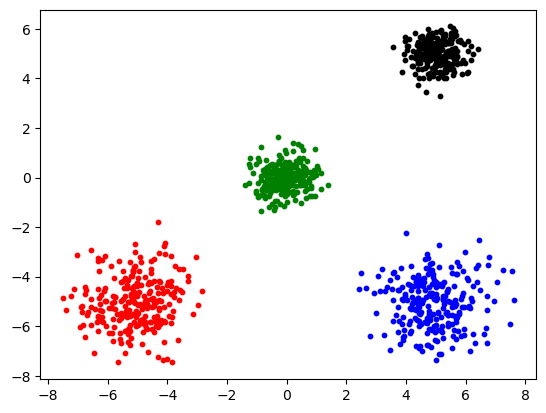

In [43]:

centers = np.array([(-5, -5), (5, -5), (0, 0), (5, 5)])
cluster_std = [1, 1, 0.5, 0.5]

X, y = make_blobs(n_samples=1000, cluster_std=cluster_std, centers=centers, n_features=2, random_state=23)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[y == 3, 0], X[y == 3, 1], color="black", s=10, label="Cluster4")
# plt.scatter(X[y == 4, 0], X[y == 4, 1], color="purple", s=10, label="Cluster4")

array([[0.58523592, 1.        ],
       [1.        , 0.        ],
       [0.09009578, 0.60765339],
       [0.        , 0.16559152]])

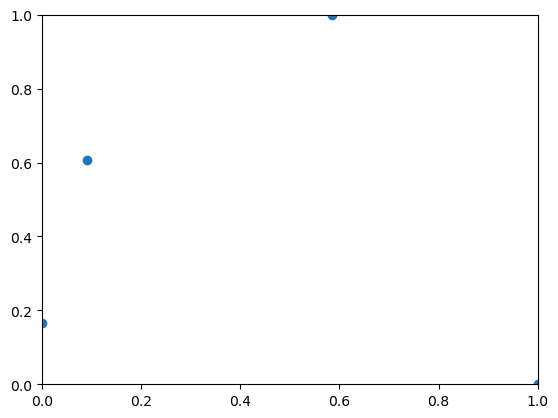

In [44]:
net = Kohonen(4, 2, manhattan_distance, euclidean_distance)
plt.scatter(net.weights[:, 0], net.weights[:, 1])
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
net.weights

In [45]:
predict = net.predict_multi(X)

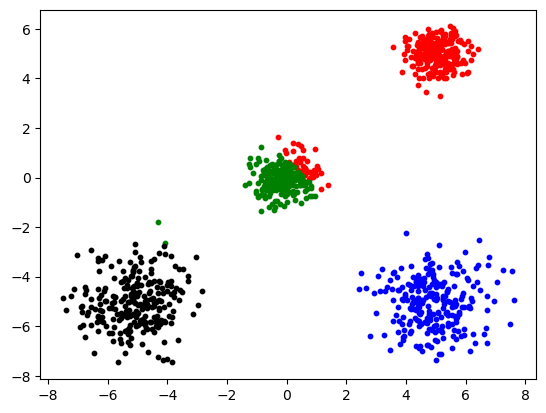

In [46]:
plt.scatter(X[predict == 0, 0], X[predict == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[predict == 1, 0], X[predict == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[predict == 2, 0], X[predict == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[predict == 3, 0], X[predict == 3, 1], color="black", s=10, label="Cluster4")
# plt.scatter(X[predict == 4, 0], X[predict == 4, 1], color="purple", s=10, label="Cluster4")

In [47]:
net.fit(X, epoch=50)
predict = net.predict_multi(X)

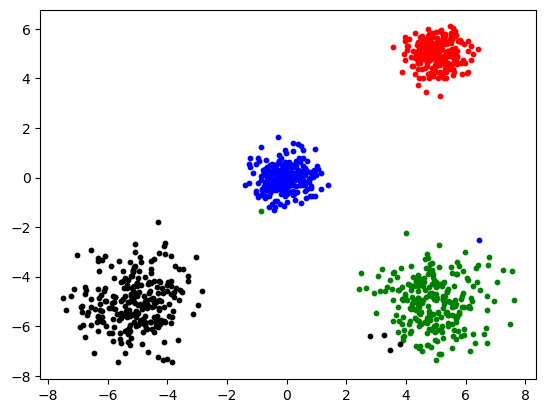

In [48]:
plt.scatter(X[predict == 0, 0], X[predict == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[predict == 1, 0], X[predict == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[predict == 2, 0], X[predict == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[predict == 3, 0], X[predict == 3, 1], color="black", s=10, label="Cluster4")
# plt.scatter(X[predict == 4, 0], X[predict == 4, 1], color="purple", s=10, label="Cluster4")

array([[0.75197239, 0.69636281],
       [0.66440568, 0.49281382],
       [0.63320914, 0.33378506],
       [0.4831015 , 0.1905781 ]])

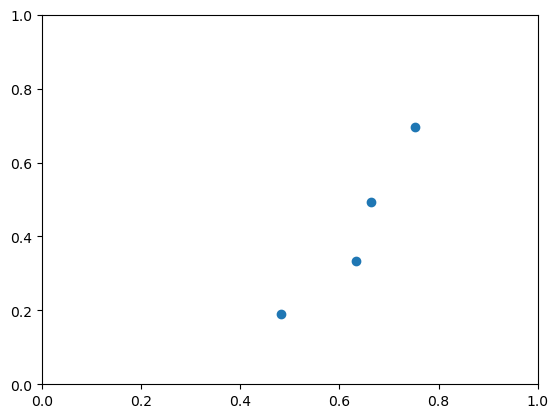

In [49]:
plt.scatter(net.weights[:, 0], net.weights[:, 1])
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
net.weights

# Check Kohonen Middle

In [50]:
net = Kohonen_middle(4, 2, 4, manhattan_distance, euclidean_distance)

In [51]:
predict = net.predict_multi(X)

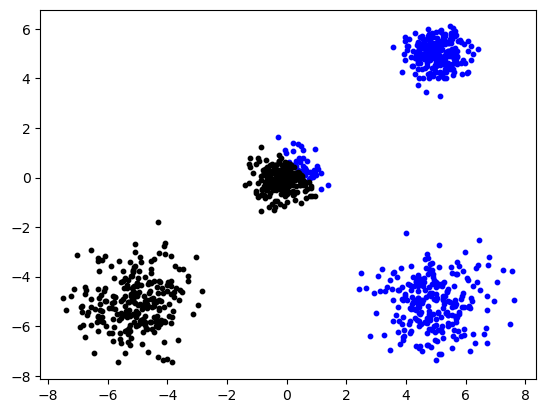

In [52]:
plt.scatter(X[predict == 0, 0], X[predict == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[predict == 1, 0], X[predict == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[predict == 2, 0], X[predict == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[predict == 3, 0], X[predict == 3, 1], color="black", s=10, label="Cluster4")
# plt.scatter(X[predict == 4, 0], X[predict == 4, 1], color="purple", s=10, label="Cluster4")

In [53]:
net.fit(X, y, epoch=50)
predict = net.predict_multi(X)

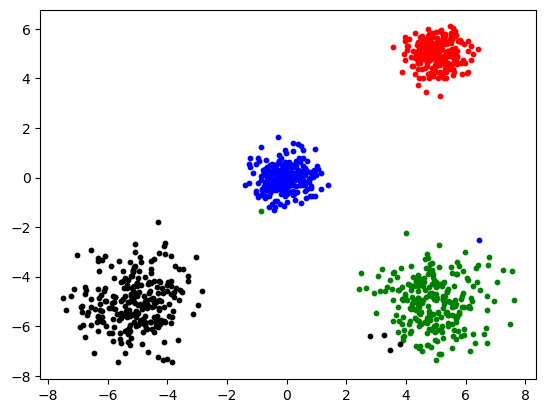

In [54]:
plt.scatter(X[predict == 0, 0], X[predict == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[predict == 1, 0], X[predict == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[predict == 2, 0], X[predict == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[predict == 3, 0], X[predict == 3, 1], color="black", s=10, label="Cluster4")
# plt.scatter(X[predict == 4, 0], X[predict == 4, 1], color="purple", s=10, label="Cluster4")